In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree, Voronoi
import sys
import pathlib

from dijkstra_search import DijkstraSearch

In [3]:

class VoronoiRoadMapPlanner:

    def __init__(self):
        # parameter
        self.N_KNN = 10  # number of edge from one sampled point
        self.MAX_EDGE_LEN = 30.0  # [m] Maximum edge length

    def planning(self, sx, sy, gx, gy, ox, oy, robot_radius):
        obstacle_tree = cKDTree(np.vstack((ox, oy)).T)

        sample_x, sample_y = self.voronoi_sampling(sx, sy, gx, gy, ox, oy)

        road_map_info = self.generate_road_map_info(
            sample_x, sample_y, robot_radius, obstacle_tree)

        rx, ry = DijkstraSearch(False).search(sx, sy, gx, gy,
                                                       sample_x, sample_y,
                                                       road_map_info)
        return rx, ry

    def is_collision(self, sx, sy, gx, gy, rr, obstacle_kd_tree):
        x = sx
        y = sy
        dx = gx - sx
        dy = gy - sy
        yaw = math.atan2(gy - sy, gx - sx)
        d = math.hypot(dx, dy)

        if d >= self.MAX_EDGE_LEN:
            return True

        D = rr
        n_step = round(d / D)

        for i in range(n_step):
            dist, _ = obstacle_kd_tree.query([x, y])
            if dist <= rr:
                return True  # collision
            x += D * math.cos(yaw)
            y += D * math.sin(yaw)

        # goal point check
        dist, _ = obstacle_kd_tree.query([gx, gy])
        if dist <= rr:
            return True  # collision

        return False  # OK

    def generate_road_map_info(self, node_x, node_y, rr, obstacle_tree):
        """
        Road map generation

        node_x: [m] x positions of sampled points
        node_y: [m] y positions of sampled points
        rr: Robot Radius[m]
        obstacle_tree: KDTree object of obstacles
        """

        road_map = []
        n_sample = len(node_x)
        node_tree = cKDTree(np.vstack((node_x, node_y)).T)

        for (i, ix, iy) in zip(range(n_sample), node_x, node_y):

            dists, indexes = node_tree.query([ix, iy], k=n_sample)

            edge_id = []

            for ii in range(1, len(indexes)):
                nx = node_x[indexes[ii]]
                ny = node_y[indexes[ii]]

                if not self.is_collision(ix, iy, nx, ny, rr, obstacle_tree):
                    edge_id.append(indexes[ii])

                if len(edge_id) >= self.N_KNN:
                    break

            road_map.append(edge_id)

        #  plot_road_map(road_map, sample_x, sample_y)

        return road_map

    @staticmethod
    def plot_road_map(road_map, sample_x, sample_y):  # pragma: no cover

        for i, _ in enumerate(road_map):
            for ii in range(len(road_map[i])):
                ind = road_map[i][ii]

                plt.plot([sample_x[i], sample_x[ind]],
                         [sample_y[i], sample_y[ind]], "-k")

    @staticmethod
    def voronoi_sampling(sx, sy, gx, gy, ox, oy):
        oxy = np.vstack((ox, oy)).T

        # generate voronoi point
        vor = Voronoi(oxy)
        sample_x = [ix for [ix, _] in vor.vertices]
        sample_y = [iy for [_, iy] in vor.vertices]

        sample_x.append(sx)
        sample_y.append(sy)
        sample_x.append(gx)
        sample_y.append(gy)

        return sample_x, sample_y


In [35]:
# start and goal position
sx = 5 # [m]
sy = 5.0  # [m]
gx = 52.0  # [m]
gy = 50.0  # [m]
robot_size = 1  # [m]

ox = []
oy = []

for i in range(60):
    ox.append(i)
    oy.append(0.0)
for i in range(60):
    ox.append(60.0)
    oy.append(i)
for i in range(61):
    ox.append(i)
    oy.append(60.0)
for i in range(61):
    ox.append(0.0)
    oy.append(i)
for i in range(40):
    ox.append(20.0)
    oy.append(i)
for i in range(40):
    ox.append(40.0)
    oy.append(60.0 - i)

rx, ry = VoronoiRoadMapPlanner().planning(sx, sy, gx, gy, ox, oy,
                                          robot_size)

assert rx, 'Cannot found path'

goal is found!


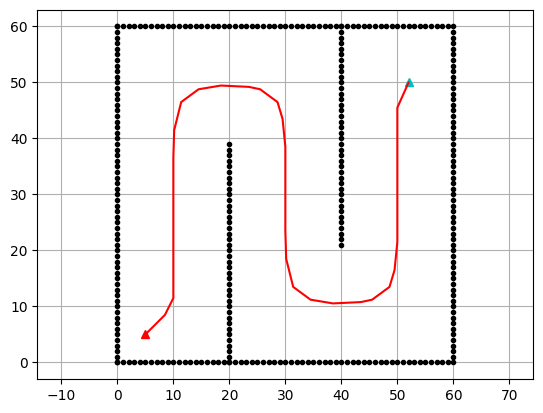

In [36]:
plt.plot(ox, oy, ".k")
plt.plot(sx, sy, "^r")
plt.plot(gx, gy, "^c")
plt.grid(True)
plt.axis("equal")
plt.plot(rx, ry, "-r")
plt.pause(0.1)
plt.show()